## Instructions

set cd to /CameraPrediction directory, then run:  
$ python -m venv .venv  
source .venv/Scripts/activate  
pip install -r requirements.txt  
  
Then select python 3.11 parking-lot-prediction recommended kernel

c:\Users\talan\.virtualenvs\parking-lot-prediction-ngy_TDrv\Lib\site-packages\ultralytics\utils\checks.py:17: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources as pkg
c:\Users\talan\.virtualenvs\parking-lot-prediction-ngy_TDrv\Lib\site-packages\ultralytics\nn\tasks.py:563: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary ob

Space A1 → empty (1.00)
Space A2 → empty (1.00)
Space A3 → empty (1.00)
Space A4 → empty (1.00)
Space A5 → empty (1.00)
Space A6 → empty (1.00)
Space B1 → empty (1.00)
Space B2 → occupied (0.89)
Space B3 → empty (1.00)
Space B4 → empty (1.00)
Space B5 → empty (1.00)
Space B6 → empty (1.00)
Space B7 → empty (1.00)
Space B8 → empty (0.71)
Space B9 → empty (1.00)
Space B10 → empty (1.00)
Space B11 → empty (1.00)
Space B12 → empty (1.00)
Space B13 → empty (1.00)
Space C1 → empty (1.00)
Space C2 → empty (1.00)
Space C3 → empty (1.00)
Space C4 → occupied (0.99)
Space C5 → empty (1.00)
Space C6 → empty (1.00)
Space C7 → occupied (1.00)
Space C8 → occupied (0.98)
Space C9 → empty (1.00)
Space C10 → occupied (0.96)
Space C11 → occupied (0.99)
Space C12 → empty (1.00)


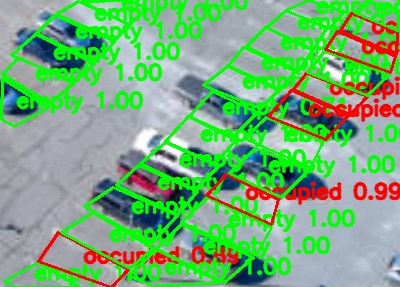

In [1]:
import json
import cv2
import numpy as np
from ultralytics import YOLO
from PIL import Image

# ---------------- CONFIG ----------------
#IMAGE_PATH = "./datasets/data/test/parklottest.jpg"
#SPACES_JSON = "./datasets/data/test/stalls.json"
IMAGE_PATH = "./datasets/data/test/pLot3.jpg"
SPACES_JSON = "./datasets/data/test/pLot3stalls.json"
MODEL_PATH = "runs/classify/train3/weights/best.pt"  # <-- must be a CLASSIFY model
IMG_SIZE = 224  # <-- must match classification training imgsz
OUT_PATH = "annotated_parklottest.jpg"
# ----------------------------------------

# Load classification model
model = YOLO(MODEL_PATH)

# Load image
img = cv2.imread(IMAGE_PATH)

# Load JSON (supports either a list OR {"spaces": [...]})
with open(SPACES_JSON, "r") as f:
    spaces = json.load(f)
    if isinstance(spaces, dict) and "spaces" in spaces:
        spaces = spaces["spaces"]

def warp_slot(image, polygon, out_size=224):
    pts = np.array(polygon, dtype=np.float32)

    # Order points: TL, TR, BR, BL (works even if user clicks in any order)
    s = pts.sum(axis=1)
    diff = np.diff(pts, axis=1).reshape(-1)

    tl = pts[np.argmin(s)]
    br = pts[np.argmax(s)]
    tr = pts[np.argmin(diff)]
    bl = pts[np.argmax(diff)]

    src = np.array([tl, tr, br, bl], dtype=np.float32)
    dst = np.array([[0, 0], [out_size, 0], [out_size, out_size], [0, out_size]], dtype=np.float32)

    M = cv2.getPerspectiveTransform(src, dst)
    return cv2.warpPerspective(image, M, (out_size, out_size))

# ---- MODEL INPUT LOOP + DRAWING ----
for space in spaces:
    poly = space["points"]  # your JSON uses "points"
    crop = warp_slot(img, poly, IMG_SIZE)

    # Convert to RGB (Ultralytics expects RGB)
    crop_rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)

    # Classification prediction
    result = model.predict(crop_rgb, imgsz=IMG_SIZE, verbose=False)[0]
    label = result.names[int(result.probs.top1)]
    conf = float(result.probs.top1conf)

    # Draw polygon on original image
    pts = np.array(poly, dtype=np.int32).reshape((-1, 1, 2))
    color = (0, 255, 0) if label.lower() == "empty" else (0, 0, 255)
    cv2.polylines(img, [pts], isClosed=True, color=color, thickness=2)

    # Put text near polygon centroid
    cx = int(np.mean([p[0] for p in poly]))
    cy = int(np.mean([p[1] for p in poly]))
    text = f"{label} {conf:.2f}"
    cv2.putText(img, text, (cx, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2, cv2.LINE_AA)

    print(f"Space {space['id']} → {label} ({conf:.2f})")

# Save + show
cv2.imwrite(OUT_PATH, img)
Image.open(OUT_PATH)